# Using nestpy to create plots of NEST curves and data
This tutorial will introduce you to the basics of plotting NEST curves, as well as some data utility functions that allow you to select datasets and compare them to the predictions made by NEST curves.

First, let's import all of the modules we're going to need. The json and glob modules are included because I have the datasets stored as JSONs, but depending on what filetype you use, you may not need them.

## What is nestpy?

## Preparing our data

In [1]:
import json
import glob
import pandas as pd
import nestpy
import numpy as np
import matplotlib.pyplot as plt

Let's open our datasets as pandas dataframes. For this tutorial, I'll use one charge yield and one light yield nuclear recoil dataset. I saved them as JSONs, but you may have them stored differently.

### Converting JSONS to pandas dataframes

In [29]:
charge_df = pd.read_json('charge/columbia_270.0_qy.json')
light_df = pd.read_json('light/xenon1t_82.0_ly.json')

dataframes = [charge_df, light_df]

If you want to load a lot of JSONs as dataframes at once, you can use the glob module to do it:

In [30]:
def load_all(pathname):
    '''
    This creates a list of dataframes created from JSONs.
    ''' 
    files = glob.glob(pathname)
#Input the pathname as wherever you have your JSONs stored.
    dfs = []
    for file in files:
        df = pd.read_json(file)
        dfs.append(df)
    return dfs

Next, we'll set up nestpy and write some functions to create NEST predictions in a format that can be easily plotted on a chart.

In nestpy, you can input various settings for the dark matter detector being used to generate predictions. In this case, we will use XENON10 for our predictions. @np.vectorize is used as a class method to make processing the NEST data easier, since there is a lot of it.

In [31]:
detector = nestpy.DetectorExample_XENON10()     
nc = nestpy.NESTcalc(detector)
@np.vectorize

#Now that we've created a detector environment in which to make our predictions, 
#it's time to to create functions to generate charge yields (in therms of electrons) and 
#light yields (in terms of photons).

def GetYieldsVectorized(interaction, yield_type, **kwargs):
    yield_object = nc.GetYields(interaction = interaction, **kwargs)
    return getattr(yield_object, yield_type) 

def ElectronYield(**kwargs):
    return GetYieldsVectorized(yield_type = 'ElectronYield', **kwargs)

def PhotonYield(**kwargs):
    return GetYieldsVectorized(yield_type = 'PhotonYield', **kwargs)

Now we can use those functions to generate datasets that can easily be graphed with matplotlib. 

The nest_curve functions takes a field strength measurement and a yield type (charge or light) and generates two lists: a list of recoil energies to graph on the x-axis, and a list of yield values for the y-axis.

The get_yields function is used to directly compare NEST predictions to real data. For each point in a given data set, a corresponding NEST yield prediction at the same field strength and recoil energy value is generated.

In [32]:
def nest_curve(field, yield_type):
    fields = np.asarray([field])
    energies = np.logspace(-1, 2, 1000,)
    energies = np.reshape(energies, (1000,1))
    energies = np.broadcast_to(energies, (len(energies), len(fields)))
    kwargs = {'energy': energies, 'drift_field': fields}
    if yield_type == 'charge':
        nest_yields = ElectronYield(interaction=nestpy.INTERACTION_TYPE.NR, **kwargs)/energies
    if yield_type == 'light':
        nest_yields = PhotonYield(interaction=nestpy.INTERACTION_TYPE.NR, **kwargs)/energies
    return (energies, nest_yields)

def get_yields(energies, field, yield_type):
    kwargs = {'energy': energies, 'drift_field': field}
    if yield_type == 'charge':
        nest_yields = ElectronYield(interaction=nestpy.INTERACTION_TYPE.NR, **kwargs)/energies
    if yield_type == 'light':
        nest_yields = PhotonYield(interaction=nestpy.INTERACTION_TYPE.NR, **kwargs)/energies
    return (nest_yields)

Now that we've written our NEST helper functions, we can create a function using matplotlib that generates a plot of our dataset, the NEST prediction curve, and a residuals subplot comparing NEST's prediction to the real data.

In [60]:
def plot_data(df, savefig=False):
    '''
    Goal: to make a scatter plot of all the different yields at various energies.
    '''
    #Uncomment these two lines if you want to include a textbox with the nestpy version:
    #version_textbox = " NEST v{0} \n nestpy v{1}".format(nestpy.__nest_version__, nestpy.__version__)
   # bbox = dict(boxstyle="round", fc="1.00", edgecolor='none')
    
    #Create the plot
    fig, (subplot1, subplot2) = plt.subplots(2, figsize=(7,5), sharex = True, gridspec_kw={'height_ratios': [3, 1]})
     
    #Get data from the dataframe
    yields = df['yield'].tolist()
    energy = df['corrected_energy'].tolist()
    driftField = df['field'].iloc[0]
    yieldType = df['yield_type'].iloc[0]    
    name = df['identification'].iloc[0]
    error_flag = False
    if 'recoil_error' in list(df.columns):
        error_flag = True
        error = df['recoil_error'].tolist()

    subplot1.scatter(energy, yields, s=15, c= '#1f77b4',label= name)
    
    #If error information is included, create y-errorbars
    
    if error_flag == True:
        subplot1.errorbar(energy, yields, yerr = df['recoil_error'].tolist(), linewidth = 1, fmt = 'none')
    else:
        pass
        
    #plotting the nest curve
    nest_label = ['NEST: ', driftField, ' V/cm']
    nest_label = ''.join(str(v) for v in nest_label)
    curve = nest_curve(driftField, yieldType)
    subplot1.plot(curve[0], curve[1], 'c--', label= nest_label)
    
    #Limit the range of the plot, for readability
    max_x, min_x, max_y, min_y = max(energy), min(energy), max(yields), min(yields)
    subplot1.set_xlim([min_x - 5, max_x + 5])
    subplot1.set_ylim([min_y - .5, max_y + .5])
    
    #Add labels and a legend
    subplot1.legend(loc='upper left') 
    subplot1.legend(prop={'size': 9})
    subplot1.set_xlabel('Recoil Energy [keV]')
    if yieldType == 'charge':
        subplot1.set_ylabel('Charge Yield [e-/keVr]') 
    else:
        subplot1.set_ylabel('Light Yield [ph/keVr]')   
   
    #Creating a subplot with residuals: 
    nest_yvals = get_yields(energy, driftField, yieldType)
    if error_flag == True:
        resid_vals = [(x - y)/z for x, y, z in zip(yields, nest_yvals, error)]
    else:
        resid_vals = [x - y for x, y in zip(yields, nest_yvals)]
    residuals = dict(zip(energy, resid_vals))
    
    subplot2.scatter(list(residuals.keys()), list(residuals.values()))
    
    #Labels and a line at 0 for the residuals subplot
    subplot2.axhline(y=0, ls= '--')
    subplot2.set_ylabel('\u03C3 (deviation)')
    
    if any(abs(x) > 10 for x in residuals.values()):
        subplot2.set_yscale('symlog')
    
    #Grid lines
    subplot1.grid(b=True)
    subplot2.grid(b=True)
    
    plt.tight_layout()
    
    if savefig: 
        plt.savefig('qy.png') 

Now it's time to plot our datasets!

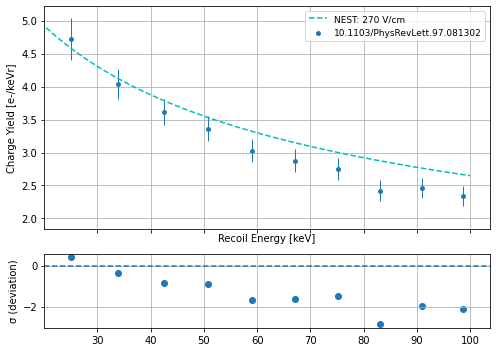

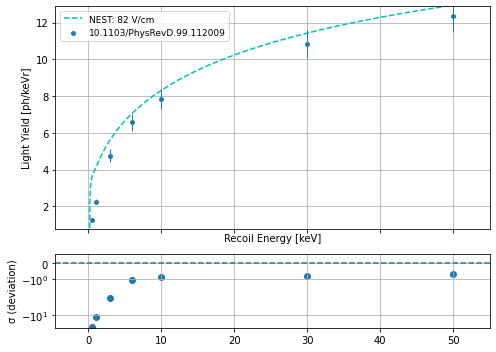

In [61]:
plot_data(charge_df)
plot_data(light_df)

I'm curious about how NEST's prediction accuracy changes with field strength, so I'll use the functions I've written to find out. First, I'll load all of the charge yield datasets. The plots wil have field strength on the x-axis and percent error on the y-axis.

In [9]:
charge_dfs = load_all('charge/*.json')
light_dfs = load_all('light/*.json')

In [46]:
def get_yield_diffs(dfs):
    yield_diffs = []
    for df in dfs:
        driftField = df['field'].iloc[0]
        yields = df['yield'].tolist()
        energy = df['corrected_energy'].tolist()
        yieldType = df['yield_type'].iloc[0]
        try:
            error = df['recoil_error'].tolist()
        except:
            pass
    
        nest_predictions = get_yields(energy, driftField, yieldType)   
        x = []
        
        for i in range(len(yields)):
            try:
                x.append([abs((yields[i] - nest_predictions[i])/nest_predictions[i]) * 100, error[i]])
            except:
                x.append([yields[i] - nest_predictions[i]])
        yield_diffs.append(x)  
    return yield_diffs

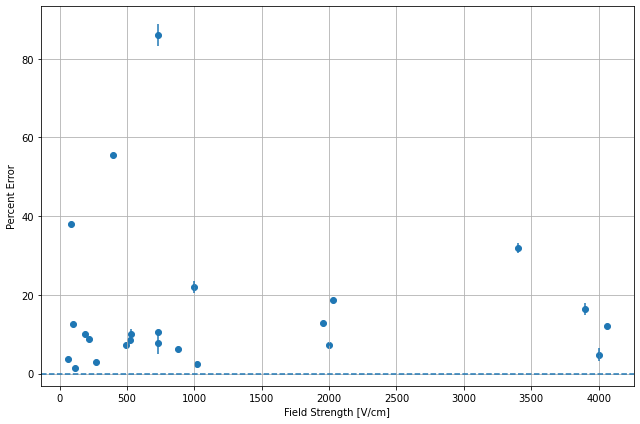

In [47]:
def plotdiffs(dfs):
    yield_diffs = get_yield_diffs(dfs)
    plt.figure(1, figsize=(9,6))
    subplot1 = plt.subplot(1,1,1)
    
    fields = []
    for df in dfs:
        fields.append(df['field'].iloc[0])   
    yvals = list(yield_diffs[i][0][0] for i in range(len(yield_diffs)))

    subplot1.scatter(fields, yvals)
    plt.errorbar(fields, yvals, yerr=list(yield_diffs[i][0][1] for i in range(len(yield_diffs))), fmt=',')
    subplot1.axhline(y=0, ls= '--')
    subplot1.set_ylabel('Percent Error')
    subplot1.set_xlabel('Field Strength [V/cm]')
    
    subplot1.grid(b=True)
    plt.tight_layout()
    
plotdiffs(charge_dfs)

Now I'll do the same thing for light yields.

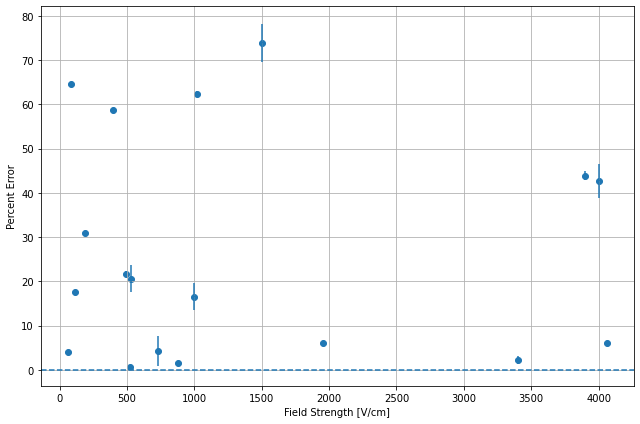

In [48]:
plotdiffs(light_dfs)